In [1]:
# Modules
import numpy as np
import xarray as xr
import pandas as pd

from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing

In [2]:
# ---
# Preprocessing
# ---

model_run = "rf002"

# Get timeseries of predictor and predictand
percentile = 0.95
predictors = ["sp", "tp", "u10", "v10",]
predictor = "sp"
season = "winter"


X, Y, t = preprocessing.preprocessing1(season, predictor, percentile)

# Handle NaN values: 
# Insert numerical value that is not in data.
# ML will hopefully recognize it.
X[np.where(np.isnan(X))] = -999

# Save number of lat/lon for interpreting model output later
ndim = X.shape[0]
nlat = X.shape[1]
nlon = X.shape[2]

# Prepare shape for model
X = X.reshape(ndim, -1) # (ndim, nclasses)
y = Y[:, 0] # Select only one station

Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load Predictand from GESLA
Applied one-hot-encoding
Get overlapping timeseries of ERA5 and GESLA


In [4]:
#---
# Train Model
#---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

# Load Hyperparameters
folder = "models/random_forest/hyperparameter/"
fname = f"{model_run}_{predictor}{str(percentile)[-2:]}.pkl"

with open(f"{folder}{fname}", 'rb') as f:
    params = pickle.load(f)

# Fit the model
model = RandomForestClassifier(criterion='gini',
n_estimators=params["n_estimators"], #- nTrees 
max_depth=params["max_depth"], 
min_samples_leaf=params["min_samples_leaf"],
min_samples_split=params["min_samples_split"],
random_state=0, # To compare results when changing hyperparameters
class_weight="balanced",
oob_score=True,
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=14,
                       min_samples_leaf=2, min_samples_split=4, oob_score=True,
                       random_state=0)

test_score: 0.8938053097345132
train_score: 0.9985228951255539
importances: [0.         0.00024752 0.00099742 ... 0.00055351 0.         0.00026344]
Metric values 

tnr: 0.9390862944162437
tpr: 0.5862068965517241
gmean: 0.741956105335083
wacc: 0.7626465954839838
precision: 0.5862068965517241
recall: 0.5862068965517241
fmeasure: 0.5862068965517241


{'tnr': 0.9390862944162437,
 'tpr': 0.5862068965517241,
 'gmean': 0.741956105335083,
 'wacc': 0.7626465954839838,
 'precision': 0.5862068965517241,
 'recall': 0.5862068965517241,
 'fmeasure': 0.5862068965517241}

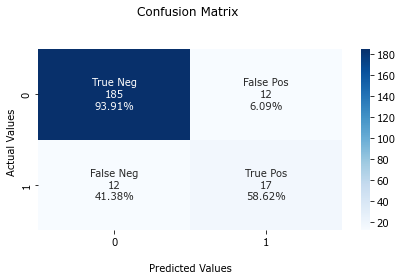

In [12]:
#---
# Evaluate model / Diagnostic
#--- 
# Score & Importance
test_score = model.score(X_test, y_test)
train_score = model.score(X_train, y_train)
importances = model.feature_importances_

print(f"test_score: {test_score}")
print(f"train_score: {train_score}")
print(f"importances: {importances}")

%matplotlib inline
#---
#  Diagnostics
#---

# Confusion matrix
#---
# Format: 
# Reality / Model: Negative, Positive
# Negative    Right Negative, False Positive 
# Positive    False Negative, Right Positive

from sklearn.metrics import confusion_matrix
from models import evaluation

y_test_pred = model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_test_pred)

cfm_fig = evaluation.plot_cf(model, X_test, y_test)
metrics = evaluation.cfm_metrics(model, X_test, y_test)

# # Save results
# folder = "results/"
# fname = f"{folder}cf_matrix.png"
# cfm_fig.savefig(fname)

In [10]:
import importlib
importlib.reload(evaluation)

<module 'models.evaluation' from 'd:\\OneDrive\\Alle_Ordner\\Coding\\Python\\master_thesis\\models\\evaluation.py'>

AUC: 0.889637668475407


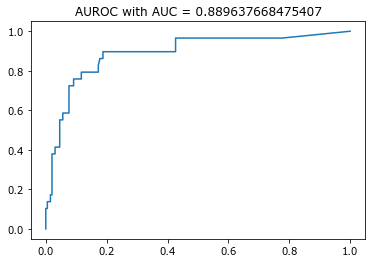

In [4]:
# AUROC
# Receiver Operating Characteristics & Area Under the Curve
#---
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_test_proba = model.predict_proba(X_test)[:, 1] # Prob. for predicting 0 or 1, we only need second col

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

print(f'AUC: {auc}')

fig, ax = plt.subplots()

plt.plot(fpr, tpr)
plt.title(f"AUROC with AUC = {auc}")
plt.show()

In [34]:
#---
# Optimization: Hyperparameters with Validation Curve
#---

# Train-Test Split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

from sklearn.model_selection import validation_curve
import numpy as np 

param_range = np.arange(0, 10, 1)
param_name = 'min_samples_leaf'

train_scores, test_scores = validation_curve(
    estimator=RandomForestClassifier(criterion="gini",
    class_weight="balanced",
    oob_score=True,
    ),
    X=X_train,
    y=y_train,
    param_name=param_name, #- varying for this parameter
    param_range=param_range, #- for this parameters
    cv=3, 
)


Import Modules

Description 

Model: Random Forest
Predictand: Classification (0,1)
Percentile Predictand: 0.95
Predictors: sp 
Seaon: winter
Preprocessing: preprocessing1
Start Preprocessing of Data


Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load Predictand from GESLA
Applied one-hot-encoding
Get overlapping timeseries of ERA5 and GESLA
Start model training

Evaluate Model 

test_score: 0.8982300884955752
train_score: 0.9556868537666174
importances: [0.00000000e+00 1.72891519e-04 2.81572627e-20 ... 4.34961487e-04
 0.00000000e+00 0.00000000e+00]
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf001.py:100: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


Show AUROC 

AUC: 0.8767722737615964


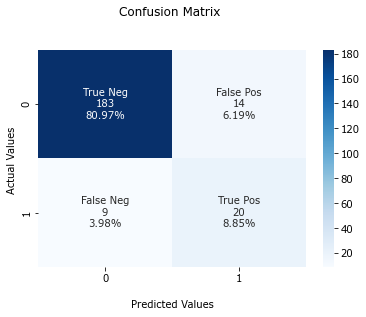

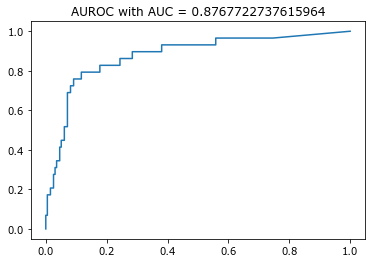

End of Model run


In [ ]:
#---
# Execute a whole experiment
#---
from models.random_forest import rf001

rf001.run()

In [ ]:
# Postprocessing

In [ ]:
# Visualization